In [127]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [128]:
class Data:
    def __init__(self, inputData):
        self.dataSeries = inputData
        self.n = inputData.size
        
    def variational_series(self):
        variational_series = self.dataSeries.value_counts().rename_axis('x_i').reset_index(name='n_i')
        variational_series = variational_series.sort_values(['x_i'])
        variational_series['w_i'] = variational_series['n_i'].apply(lambda n_i: n_i/self.n)
        return variational_series
    
    def series_polygon(self):
        fig, ax = plt.subplots()
        ax.plot('x_i', 'w_i', data=self.variational_series(), marker='.', linewidth = 2)
        
        ax.xaxis.set_major_locator(ticker.MultipleLocator(50))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(0.005))
        ax.grid(which='major', color = 'gray', linestyle = ':')
        ax.set_xlabel('x_i')
        ax.set_ylabel('w_i')
    
    def discrete_F(self):
        xData = self.variational_series()['x_i'].tolist()
        wData = self.variational_series()['w_i'].tolist()
        result = []
        
        value = 0
        i = 0
        j = -1
        
        sheets = [f'(-inf, {xData[0]}]']
        F = [0]
        
        for x in np.linspace(xData[0], xData[-1], 100):
            if x <= xData[i]:
                result.append(value)
            else:
                sheets.append(f'({xData[i]}, {xData[i + 1]}]')
                i += 1
                j += 1
                value += wData[j]
                F.append(value)
                result.append(value)
                
        sheets.append(f'({xData[-1]}, inf)')
        F.append(1)
        df = pd.DataFrame(zip(sheets, F), columns=['interval', 'F'])
        
        return df, result
    
    
    def interval_series(self):
        xData = self.variational_series()['x_i'].tolist()
        nData = self.variational_series()['n_i'].tolist()
        
        k = 1 + 3.322 * np.log10(self.n)
        h = round((xData[-1] - xData[0]) / k, 3)
        value = xData[0] - h / 2
        
        intervalStart = []
        intervalEnd = []
        n = []
        
        while True:
            intervalStart.append(round(value, 4))
            value += h
            intervalEnd.append(round(value, 4))
            
            if value >= xData[-1]:
                break
        intervalStart[0] = xData[0]
        intervalEnd[-1] = xData[-1]
        
        n_i = 0
        for i in range(len(intervalStart)):
            for j in range(len(xData)):
                if (xData[j] >= intervalStart[i]) and (xData[j] <= intervalEnd[i]):
                    n_i += nData[j]
            n.append(n_i)
            n_i = 0
        
        df = pd.DataFrame(zip(intervalStart, intervalEnd, n), columns=['start', 'end', 'n_i'])
        df['w_i'] = df['n_i'].apply(lambda n_i: n_i/self.n)
        df['w_i/h'] = df['w_i'].apply(lambda n_i: round(n_i/h, 3))
            
        return df
    
    def interval_polygon(self):
        fig, ax = plt.subplots()
        
        xStartData = self.interval_series()['start'].tolist()
        xEndData = self.interval_series()['end'].tolist()
        wData = self.interval_series()['w_i'].tolist()
        
        x = []
        for i in range(len(xStartData)):
            x.append((xStartData[i] + xEndData[i]) / 2)
        
        ax.plot(x, wData, marker='.', linewidth = 2)
        
        ax.xaxis.set_major_locator(ticker.MultipleLocator(50))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(0.01))
        ax.grid(which='major', color = 'gray', linestyle = ':')
        ax.set_xlabel('x_i')
        ax.set_ylabel('w_i')
    
    def interval_F(self):
        xData = self.variational_series()['x_i'].tolist()
        nData = self.interval_series()['n_i'].tolist()
        intervalStart = self.interval_series()['start'].tolist()
        intervalEnd = self.interval_series()['end'].tolist()
        
        F = [0]
        value = 0
        for i in range(len(intervalEnd) - 1):
            value += nData[i] / self.n
            F.append(round(value, 4))
        F.append(1)
        
        df = pd.DataFrame(zip([intervalStart[0]] + intervalEnd, F), columns=['x', 'F'])
        
        return F, df

    def F_plot(self, mod):     
        fig, ax = plt.subplots()
        
        ax.xaxis.set_major_locator(ticker.MultipleLocator(50))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(0.05))
        ax.grid(which='major', color = 'gray', linestyle = ':')
        ax.set_xlabel('x_i')
        ax.set_ylabel('F')
        
        if mod == 1:
            xData = self.variational_series()['x_i'].tolist()
            wData = self.variational_series()['w_i'].tolist()
            
            x = np.linspace(xData[0], xData[-1], 100)
            w = self.discrete_F()[1]
            w[0] = w[2]
            ax.plot(x, w, linewidth = 2, color='b')
            
        if mod == 2:
            xData = self.variational_series()['x_i'].tolist()
            
            x = [xData[0]] + self.interval_series()['end'].tolist()
            y = self.interval_F()[0]
            ax.plot(x, y, linewidth = 2, color='r', marker='.')
            
        if mod == 3:
            xData = self.variational_series()['x_i'].tolist()
            wData = self.variational_series()['w_i'].tolist()
            w = self.discrete_F()[1]
            x1 = np.linspace(xData[0], xData[-1], 100)
            w[0] = w[2]
            
            ax.plot(x1, w, linewidth = 2, color='b')
            
            x2 = [xData[0]] + self.interval_series()['end'].tolist()
            y = self.interval_F()[0]
            
            ax.plot(x2, y, linewidth = 2, color='r', marker='.')

    def w_histogram(self):
        intervalStart = self.interval_series()['start'].tolist()
        intervalEnd = self.interval_series()['end'].tolist()
        
        n, bins, rects = plt.hist([], bins=[intervalStart[0]] + intervalEnd, ec='k')
        
        for i in range(len(rects)):
            rects[i].set_height(self.interval_series()['w_i/h'].tolist()[i])

        plt.ylim(0, max(self.interval_series()['w_i/h'].tolist()))
        plt.show()
        

In [129]:
inputData = pd.read_csv(r'C:\Users\charl\Downloads\Statistica\CalcAndGraphic\Work1\data.csv')
FuelWasteData = Data(inputData)

In [131]:
FuelWasteData.variational_series()

,x_i,n_i,w_i
13,6500,1,0.033333
15,6530,1,0.033333
2,6540,2,0.066667
21,6620,1,0.033333
20,6650,1,0.033333
19,6660,1,0.033333
18,6670,1,0.033333
17,6690,1,0.033333
4,6700,2,0.066667
16,6710,1,0.033333


In [132]:
FuelWasteData.variational_series()['n_i'].sum(), FuelWasteData.variational_series()['w_i'].sum()

(30, 1.0)

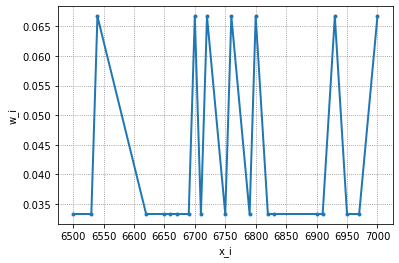

In [133]:
FuelWasteData.series_polygon()

In [134]:
FuelWasteData.discrete_F()[0]

,interval,F
0,"(-inf, 6500]",0.000000
1,"(6500, 6530]",0.033333
2,"(6530, 6540]",0.066667
3,"(6540, 6620]",0.133333
4,"(6620, 6650]",0.166667
5,"(6650, 6660]",0.200000
6,"(6660, 6670]",0.233333
7,"(6670, 6690]",0.266667
8,"(6690, 6700]",0.300000
9,"(6700, 6710]",0.366667


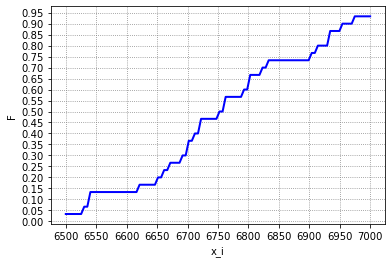

In [135]:
FuelWasteData.F_plot(1)

In [136]:
FuelWasteData.interval_series()

,start,end,n_i,w_i,w_i/h
0,6500.0000,6542.3225,4,0.133333,0.002
1,6542.3225,6626.9675,1,0.033333,0.000
2,6626.9675,6711.6125,7,0.233333,0.003
3,6711.6125,6796.2575,6,0.200000,0.002
4,6796.2575,6880.9025,4,0.133333,0.002
5,6880.9025,6965.5475,5,0.166667,0.002
6,6965.5475,7000.0000,3,0.100000,0.001


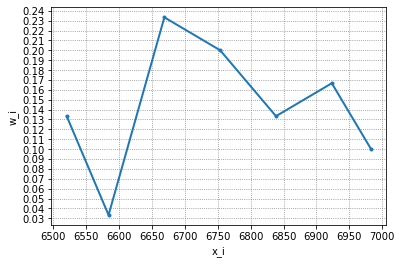

In [137]:
FuelWasteData.interval_polygon()

In [138]:
FuelWasteData.interval_F()[1]

,x,F
0,6500.0000,0.0000
1,6542.3225,0.1333
2,6626.9675,0.1667
3,6711.6125,0.4000
4,6796.2575,0.6000
5,6880.9025,0.7333
6,6965.5475,0.9000
7,7000.0000,1.0000


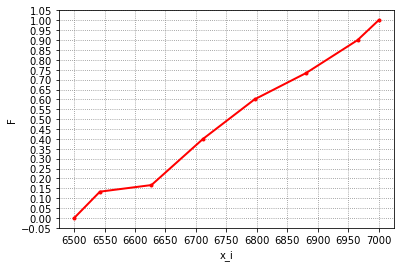

In [139]:
FuelWasteData.F_plot(2)

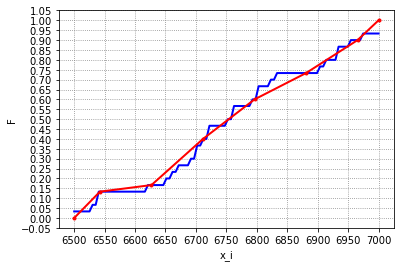

In [125]:
FuelWasteData.F_plot(3)

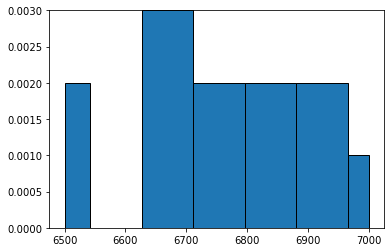

In [126]:
FuelWasteData.w_histogram()